In [186]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.metrics import euclidean_distances
from collections import OrderedDict


In [188]:
run "Step6.ipynb"

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/2647164128.py:20: RuntimeWarning:

divide by zero encountered in scalar divide



# Testing

### Metrics formulas

In [193]:
def compute_continuity(similarities, distances_Y, k=5):
    
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        V = np.setdiff1d(knn_orig[i], knn_proj[i])

        sum_j = 0
        for j in range(V.shape[0]):
            sum_j += np.where(nn_proj[i] == V[j])[0] - k

        sum_i += sum_j

    return float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())

def compute_trustworthiness(similarities, distances_Y, k=5):
    
    n = len(similarities)

    nn_orig = similarities.argsort()
    nn_proj = distances_Y.argsort()

    knn_orig = nn_orig[:, :k + 1][:, 1:]
    knn_proj = nn_proj[:, :k + 1][:, 1:]

    sum_i = 0

    for i in range(n):
        U = np.setdiff1d(knn_proj[i], knn_orig[i])

        sum_j = 0
        for j in range(U.shape[0]):
            sum_j += np.where(nn_orig[i] == U[j])[0] - k

        sum_i += sum_j

    trustworthiness_score = float((1 - (2 / (n * k * (2 * n - 3 * k - 1)) * sum_i)).squeeze())
    return trustworthiness_score

def compute_stress(similarities, distances_Y):
    
    stress = np.sum((similarities - distances_Y)**2) / np.sum(similarities**2)

    return stress

def compute_shepard(distances, distances_Y):
    
    plt.scatter(distances.flatten(), distances_Y.flatten())
    plt.xlabel('Original Distances')
    plt.ylabel('Transformed Distances')
    plt.title('Shepard Plot')
    plt.show()

### t-sne for testing

In [197]:
def plot_tsne_testing(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric='precomputed')
    embeddings = tsne.fit_transform(distances)
    #print(f"Embeddings: {embeddings.flatten()}")
    distances_Y = euclidean_distances(embeddings)

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

# Metrics miserables

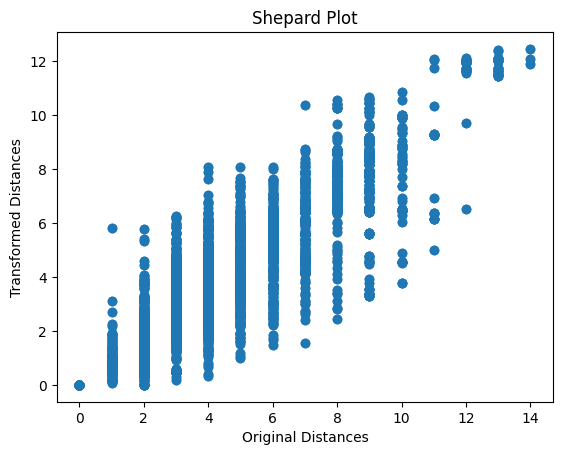

Continuity 0.9223414266892528
Trustworthiness 0.9319781667607755
Stress 0.07493838286894458


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/3617847669.py:17: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



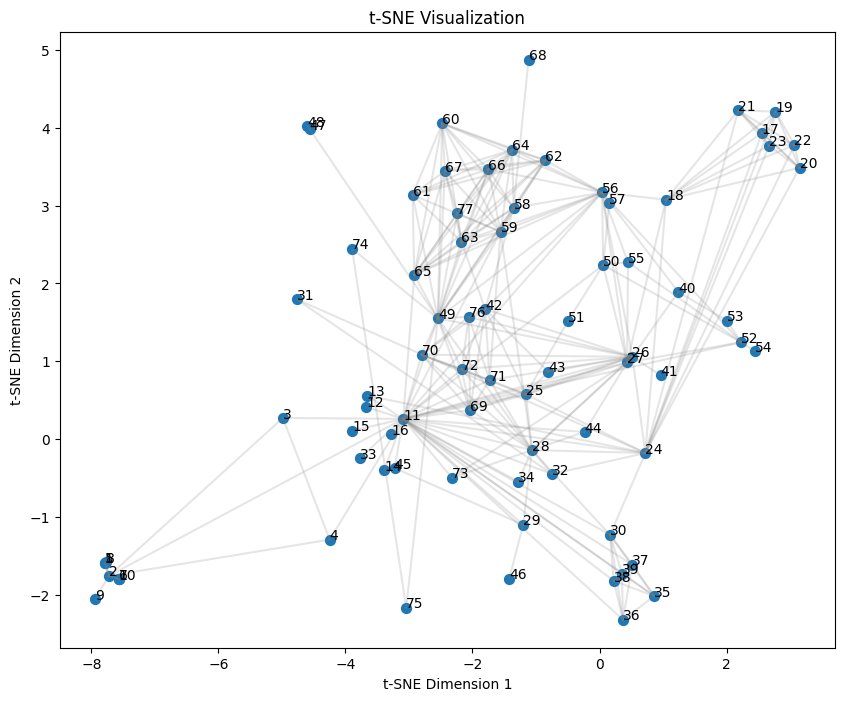

In [198]:
nodes, edges, node_list, edge_list, weights = get_data_step6('Datasets/LesMiserables.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing(distances, node_list, edge_list, perplexity=25,learning_rate=100, n_iter=1000)


# Metrics League

In [180]:
def get_data_negative(dot_file_path):
    '''Returns the nodes, edges (both in pydot format), a list with all the nodes and another with all the edges, and also a dic with (edge):weigth
    '''
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    
    weights = {}
    if edges[0].get_attributes():
        name = str(list(edges[0].get_attributes().keys())[0])
        weights = {(edge.get_source(), edge.get_destination()): int(edge.get_attributes()[name].strip('"')) for edge in edges}

    return nodes, edges, node_list, edge_list, weights

def floyd_warshall_league(node_list, edge_list, weights):
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    np.fill_diagonal(distances, 0)

    for (u, v), weight in weights.items():
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = weight

    for k in range(num_nodes):
        for i in range(num_nodes):
            for j in range(num_nodes):
                if distances[i, k] + distances[k, j] < distances[i, j]:
                    distances[i, j] = distances[i, k] + distances[k, j]

    # Check for negative cycles
    for i in range(num_nodes):
        if distances[i, i] < 0:
            raise ValueError("Graph contains a negative cycle")

    return distances

def plot_tsne_testing_league(distances, node_list, edge_list, perplexity=10, learning_rate=30, n_iter=1000):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='random', metric="precomputed")
    distances = np.abs(distances)
    embeddings = tsne.fit_transform(distances)
    #print(f"Embeddings: {embeddings.flatten()}")
    distances_Y = euclidean_distances(embeddings)

    continuity_score = compute_continuity(distances, distances_Y)
    trustworthiness_score = compute_trustworthiness(distances, distances_Y)
    stress = compute_stress(distances, distances_Y)
    shepard_values = compute_shepard(distances, distances_Y)

    print(f"Continuity {continuity_score}")
    print(f"Trustworthiness {trustworthiness_score}")
    print(f"Stress {stress}")

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                 [embeddings[u_index, 1], embeddings[v_index, 1]], 
                 color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    #plt.grid(True)
    #plt.colorbar(label='Similarity')
    plt.show()

nodes, edges, node_list, edge_list, weights = get_data_negative('Datasets/LeagueNetwork.dot')
distances = floyd_warshall_league(node_list, edge_list, weights)
#print(distances)
plot_tsne_testing_league(distances, node_list, edge_list, perplexity=15,learning_rate=100, n_iter=1000)

ValueError: Graph contains a negative cycle

# Metrics Jazz

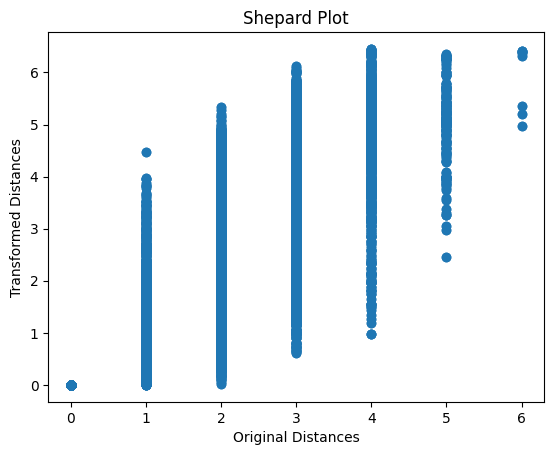

Continuity 0.8739553429027114
Trustworthiness 0.884013822434875
Stress 0.18962773177048098


/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_60450/3960689742.py:17: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



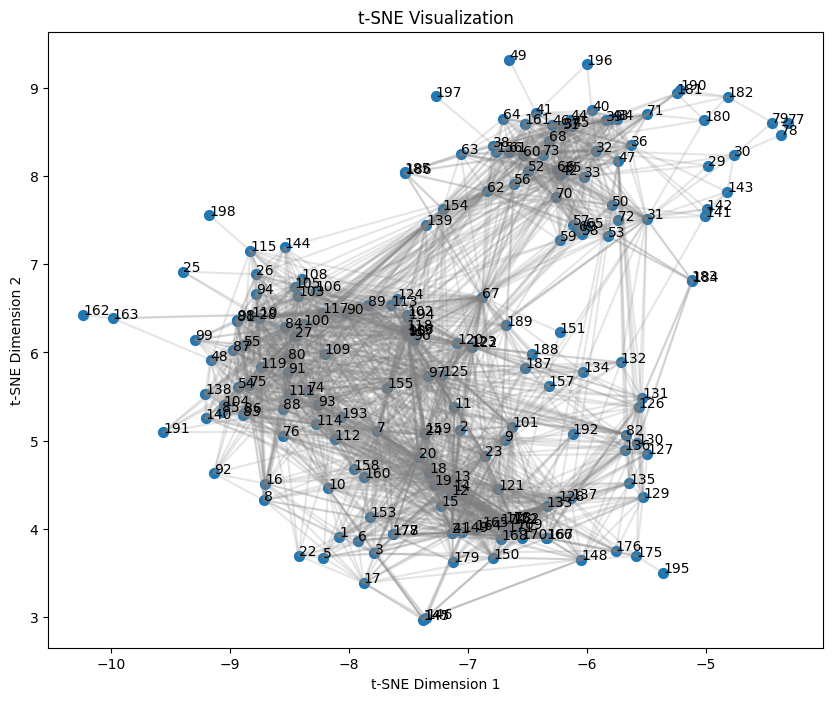

In [196]:
def get_data_jazz(dot_file_path):
   # = 'Datasets/LesMiserables.dot'
    with open(dot_file_path, 'r') as dot_file:
        dot_data = dot_file.read()
    graph = pydot.graph_from_dot_data(dot_data)

    nodes = graph[0].get_nodes()
    edges = graph[0].get_edges()
    
    node_list = [node.get_name() for node in nodes]
    edge_list = [(edge.get_source(), edge.get_destination()) for edge in edges]
    weights = {(edge.get_source(), edge.get_destination()):1 for edge in edges}
    
    return nodes,edges,node_list,edge_list,weights

nodes, edges, node_list, edge_list, weights = get_data_jazz('Datasets/Jazznetwork.dot')
distances = floyd_warshall(node_list, edge_list, weights)
plot_tsne_testing(distances, node_list, edge_list, perplexity=90,learning_rate=500, n_iter=1000)

# ////////////////////////////// TRASH ////////////////////////////////////

# Check divergence

In [ ]:
def plot_tsne(distances, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750, interactive=False):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, init='pca')
    embeddings = tsne.fit_transform(distances)

    
    kl_div = tsne.kl_divergence_
    for i in range(n_iter):
        print(f"Iteration {i+1}: KL divergence = {kl_div}")
        if kl_div < 0.05:
            print(f"t-SNE has converged in iteration n. {i+1}")
            break

    # KMeans clustering
    # kmeans = KMeans(n_clusters=8)  # You can adjust the number of clusters
    # labels = kmeans.fit_predict(embeddings)

    plt.figure(figsize=(10, 8))
    #plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap='viridis', s=50)

    for edge in edge_list:
        u, v = edge
        u_index = node_list.index(u)
        v_index = node_list.index(v)
        plt.plot([embeddings[u_index, 0], embeddings[v_index, 0]], 
                    [embeddings[u_index, 1], embeddings[v_index, 1]], 
                    color='gray', alpha=0.2)

    for i, node_number in enumerate(node_list):
        plt.text(embeddings[i, 0], embeddings[i, 1], node_number, color='black')

    plt.title('t-SNE Visualization of Node Similarities')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    #plt.colorbar(label='Cluster ID')
    plt.colorbar(label='Similarity')
    plt.show()